In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

DATA = Path("/Users/havyanimmagadda/Desktop/MBL")       # adjust if your path differs
OUT  = DATA / "outputs"
OUT.mkdir(exist_ok=True, parents=True)


In [ ]:
bref    = pd.read_csv(DATA/"mlb_bref_team_results_2015_2024.csv")
travel  = pd.read_csv(DATA/"mlb_travel_data.csv")
batting = pd.read_csv(DATA/"batting_final_7teams.csv")
pitch   = pd.read_csv(DATA/"pitching_final_7teams.csv")

print("Loaded shapes:")
print("BREF:", bref.shape)
print("Travel:", travel.shape)
print("Batting:", batting.shape)
print("Pitching:", pitch.shape)


Loaded shapes:
BREF: (9105, 24)
Travel: (10939, 12)
Batting: (5122, 54)
Pitching: (5122, 63)


In [ ]:
def clean_cols(df):
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

bref = clean_cols(bref)
travel = clean_cols(travel)
batting = clean_cols(batting)
pitch = clean_cols(pitch)


In [ ]:
def parse_bref_date(row):
    txt = str(row["date"])
    yr = int(row["year"])
    try:
        if "," in txt:
            txt2 = txt.split(",", 1)[1].strip()
            dt = datetime.strptime(f"{txt2} {yr}", "%b %d %Y")
        else:
            dt = datetime.strptime(f"{txt} {yr}", "%b %d %Y")
        return dt
    except Exception:
        try:
            return datetime.strptime(f"{row['date']} {yr}", "%A, %b %d %Y")
        except Exception:
            return pd.NaT

bref["game_date"] = bref.apply(parse_bref_date, axis=1)
bref["team_code"] = bref.get("tm", bref.get("team")).astype(str).str.upper()
bref["win_binary"] = bref["result"].astype(str).str.upper().str.startswith("W").astype(int)
bref["home_away"] = bref.get("h_a", bref.get("home_away"))
bref["runs_scored"] = bref.get("r", bref.get("runs_scored"))
bref["runs_allowed"] = bref.get("ra", bref.get("runs_allowed"))

bref_min = bref[["team_code","game_date","win_binary","home_away","runs_scored","runs_allowed"]].dropna()


In [ ]:
# STEP 4 — Clean Travel Dataset (Safe)

# 1. Make sure we have a date column
date_col_candidates = [c for c in travel.columns if "date" in c]
if len(date_col_candidates) == 0:
    raise ValueError("No date-like column found in travel CSV.")
else:
    date_col = date_col_candidates[0]

travel["game_date"] = pd.to_datetime(travel[date_col], errors="coerce")

# 2. Identify/create team_code
# Check common possibilities
possible_team_cols = ["team_code", "team", "tracked_team", "club", "teamname"]

team_col = None
for c in possible_team_cols:
    if c in travel.columns:
        team_col = c
        break

if team_col is None:
    raise ValueError(f"No team identifier found. Columns available: {travel.columns.tolist()}")

# Create normalized team_code
travel["team_code"] = travel[team_col].astype(str).str.upper()

# If the column contains names ("BOSTON RED SOX"), extract 3-letter code
if travel["team_code"].str.len().max() > 4:
    travel["team_code"] = travel["team_code"].apply(lambda x: x[:3].upper())

# 3. Ensure distance columns exist
for c in ["lat", "lon", "team_leg_miles", "away_leg_miles", "home_leg_miles"]:
    if c not in travel.columns:
        travel[c] = np.nan

# 4. Reduce to essential columns
travel_min = travel[[
    "team_code", "game_date",
    "lat", "lon",
    "team_leg_miles", "away_leg_miles", "home_leg_miles"
]]

# 5. Aggregate to UNIQUE team-date rows (avoid duplicates)
travel_agg = (
    travel_min
    .groupby(["team_code", "game_date"], as_index=False)
    .agg({
        "lat": "first",
        "lon": "first",
        "team_leg_miles": "sum",
        "away_leg_miles": "sum",
        "home_leg_miles": "sum",
    })
)

print("✔ Travel dataset cleaned and aggregated.")
print("Travel head:")
display(travel_agg.head())



✔ Travel dataset cleaned and aggregated.
Travel head:


,team_code,game_date,lat,lon,team_leg_miles,away_leg_miles,home_leg_miles
0,BOS,2015-04-06,39.9057,-75.1665,541.370981,541.370981,0.0
1,BOS,2015-04-08,39.9057,-75.1665,0.000000,0.000000,0.0
2,BOS,2015-04-09,39.9057,-75.1665,0.000000,0.000000,0.0
3,BOS,2015-04-10,40.8296,-73.9262,182.623980,182.623980,0.0
4,BOS,2015-04-11,40.8296,-73.9262,0.000000,0.000000,0.0


In [ ]:
# Step 5: Merge Baseball-Reference results with travel data
# --------------------------------------------------------
# Inputs:
#   - bref_min   : game-level results (team_code, game_date, win, runs, home/away)
#   - travel_agg : game-level travel data (team_code, game_date, miles, lat/lon)
#
# Goal:
#   - Combine into a single "merged" table
#   - Create leg_miles (distance for that game)
#   - Create rest_days (days since previous game for that team)
#   - Create is_home flag (1 = home, 0 = away)

# 1) Merge on team_code + game_date
merged = (
    bref_min.merge(
        travel_agg,
        on=["team_code", "game_date"],   # join keys
        how="left"                       # keep all games, even if missing travel
    )
    .sort_values(["team_code", "game_date"])
    .reset_index(drop=True)
)

# 2) Make sure game_date is in datetime format for date math (rest_days)
merged["game_date"] = pd.to_datetime(merged["game_date"], errors="coerce")

# 3) Create leg_miles: prefer team_leg_miles, then away/home, else 0
#    This gives one distance value per game for the team.
merged["leg_miles"] = merged["team_leg_miles"].fillna(0)
merged.loc[merged["leg_miles"] == 0, "leg_miles"] = merged["away_leg_miles"].fillna(0)
merged.loc[merged["leg_miles"] == 0, "leg_miles"] = merged["home_leg_miles"].fillna(0)

# 4) Create rest_days: difference in days between consecutive games for each team
#    groupby team_code, then diff on the game_date, convert to days.
merged["rest_days"] = (
    merged
    .groupby("team_code")["game_date"]
    .diff()                                # timedelta between this game and previous game
    .dt.days
    .fillna(1)                             # first game of season: treat as 1 day of rest
    .clip(lower=0)                         # no negative rest
)

# 5) Create is_home: from home_away column (H/A)
merged["is_home"] = (
    merged["home_away"]
    .astype(str)
    .str.upper()
    .str.startswith("H")                   # True if string starts with "H"
    .astype(int)                           # convert True/False → 1/0
)

In [ ]:
print("Merged shape:", merged.shape)
print("Teams in merged:", sorted(merged["team_code"].unique()))
print("Date range:", merged["game_date"].min(), "→", merged["game_date"].max())

merged.head(10)


Merged shape: (8831, 14)
Teams in merged: ['BOS', 'CHC', 'MIA', 'SDP', 'SEA', 'STL']
Date range: 2015-04-05 00:00:00 → 2024-09-29 00:00:00


,team_code,game_date,win_binary,home_away,runs_scored,runs_allowed,lat,lon,team_leg_miles,away_leg_miles,home_leg_miles,leg_miles,rest_days,is_home
0,BOS,2015-04-06,1,A,8,0,39.9057,-75.1665,541.370981,541.370981,0.000000,541.370981,1.0,0
1,BOS,2015-04-08,0,A,2,4,39.9057,-75.1665,0.000000,0.000000,0.000000,0.000000,2.0,0
2,BOS,2015-04-09,1,A,6,2,39.9057,-75.1665,0.000000,0.000000,0.000000,0.000000,1.0,0
3,BOS,2015-04-10,1,A,6,5,40.8296,-73.9262,182.623980,182.623980,0.000000,182.623980,1.0,0
4,BOS,2015-04-11,1,A,8,4,40.8296,-73.9262,0.000000,0.000000,0.000000,0.000000,1.0,0
5,BOS,2015-04-12,0,A,4,14,40.8296,-73.9262,0.000000,0.000000,0.000000,0.000000,1.0,0
6,BOS,2015-04-13,1,H,9,4,42.3467,-71.0972,359.750962,0.000000,359.750962,359.750962,1.0,1
7,BOS,2015-04-14,1,H,8,7,42.3467,-71.0972,0.000000,0.000000,0.000000,0.000000,1.0,1
8,BOS,2015-04-15,0,H,5,10,42.3467,-71.0972,0.000000,0.000000,0.000000,0.000000,1.0,1
9,BOS,2015-04-17,1,H,3,2,42.3467,-71.0972,0.000000,0.000000,0.000000,0.000000,2.0,1


In [ ]:
# STEP 6 — Merge batting + pitching per-game data
# --------------------------------------------------

# 1) Normalize date & team_code in batting
batting["game_date"] = pd.to_datetime(batting["game_date"], errors="coerce")
batting["team_code"] = batting["team_code"].astype(str).str.upper()

# 2) Normalize date & team_code in pitching
pitch["game_date"] = pd.to_datetime(pitch["game_date"], errors="coerce")
pitch["team_code"] = pitch["team_code"].astype(str).str.upper()

# 3) Select columns (avoid hundreds of columns)
bat_keep = ["team_code","game_date"] + [
    c for c in batting.columns 
    if c not in ["team_code","game_date"] and batting[c].dtype != "object"
][:20]

pit_keep = ["team_code","game_date"] + [
    c for c in pitch.columns
    if c not in ["team_code","game_date"] and pitch[c].dtype != "object"
][:20]

bat_small = batting[bat_keep]
pit_small = pitch[pit_keep]

# 4) Merge into your merged dataset (game-level)
merged = (
    merged
    .merge(bat_small, on=["team_code","game_date"], how="left", suffixes=("", "_bat"))
    .merge(pit_small, on=["team_code","game_date"], how="left", suffixes=("", "_pit"))
)

print("Merged shape with batting & pitching:", merged.shape)
merged.head(10)


Merged shape with batting & pitching: (8831, 54)


,team_code,game_date,win_binary,home_away,runs_scored,runs_allowed,lat,lon,team_leg_miles,away_leg_miles,...,pitching_stats_bb,pitching_stats_ibb,pitching_stats_so,pitching_stats_hbp,pitching_stats_bk,pitching_stats_wp,pitching_stats_bf,pitching_stats_era,pitching_stats_fip,pitching_stats_pit
0,BOS,2015-04-06,1,A,8,0,39.9057,-75.1665,541.370981,541.370981,...,2.0,0.0,9.0,0.0,0.0,0.0,33.0,0.00,1.80,118.0
1,BOS,2015-04-08,0,A,2,4,39.9057,-75.1665,0.000000,0.000000,...,2.0,0.0,7.0,0.0,0.0,1.0,34.0,1.59,2.72,127.0
2,BOS,2015-04-09,1,A,6,2,39.9057,-75.1665,0.000000,0.000000,...,3.0,0.0,10.0,0.0,0.0,1.0,35.0,1.73,2.44,137.0
3,BOS,2015-04-10,1,A,6,5,40.8296,-73.9262,182.623980,182.623980,...,6.0,1.0,13.0,1.0,0.0,0.0,75.0,2.00,3.20,296.0
4,BOS,2015-04-11,1,A,8,4,40.8296,-73.9262,0.000000,0.000000,...,2.0,0.0,11.0,0.0,0.0,1.0,34.0,2.33,3.13,128.0
5,BOS,2015-04-12,0,A,4,14,40.8296,-73.9262,0.000000,0.000000,...,6.0,0.0,5.0,0.0,0.0,0.0,44.0,3.92,3.89,166.0
6,BOS,2015-04-13,1,H,9,4,42.3467,-71.0972,359.750962,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BOS,2015-04-14,1,H,8,7,42.3467,-71.0972,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BOS,2015-04-15,0,H,5,10,42.3467,-71.0972,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BOS,2015-04-17,1,H,3,2,42.3467,-71.0972,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

# 1) Extract timezone from lon (approximate)
def approximate_timezone(lon):
    return int(round(lon / 15))  # each 15° longitude ≈ 1 hour

merged["tz_offset"] = merged["lon"].apply(lambda x: approximate_timezone(x) if pd.notna(x) else 0)

# 2) Convert to EST = offset - (-5)
merged["tz_relative_est"] = merged["tz_offset"] - (-5)

# 3) Jetlag change between games
merged["prev_tz_offset"] = merged.groupby("team_code")["tz_offset"].shift(1)
merged["jetlag_change"] = (merged["tz_offset"] - merged["prev_tz_offset"]).fillna(0)


In [ ]:
# STEP 8 — Create KPIs (batting, pitching, fielding)
# -----------------------------------------------------

# Example batting KPIs
if "hits_bat" in merged.columns:
    merged["batting_quality"] = (
        merged["hits_bat"] +
        merged.get("hr_bat", 0)*2 -
        merged.get("so_bat", 0)
    )

# Example pitching KPIs
if "er_pit" in merged.columns:
    merged["pitch_quality"] = (
        -1 * merged["er_pit"] * 2 +
        merged.get("so_pit", 0)
    )

# Example fielding KPI (if available)
if "errors" in merged.columns:
    merged["fielding_quality"] = -1 * merged["errors"]


In [ ]:

def add_final_features(g):
    g = g.sort_values("game_date").copy()

    # Travel features
    g["travel_3g_avg"] = g["leg_miles"].rolling(3).mean().shift(1)
    g["travel_7g_avg"] = g["leg_miles"].rolling(7).mean().shift(1)
    g["travel_intensity"] = g["leg_miles"].rolling(7).sum().shift(1) / 7

    # Jetlag
    g["jetlag_3g"] = g["jetlag_change"].rolling(3).mean().shift(1)

    # Batting KPIs
    if "batting_quality" in g:
        g["batting_3g"] = g["batting_quality"].rolling(3).mean().shift(1)

    # Pitching KPIs
    if "pitch_quality" in g:
        g["pitching_3g"] = g["pitch_quality"].rolling(3).mean().shift(1)

    # Fielding
    if "fielding_quality" in g:
        g["fielding_3g"] = g["fielding_quality"].rolling(3).mean().shift(1)

    return g

features = merged.groupby("team_code", group_keys=False).apply(add_final_features)
print(features.head(10))


  team_code  game_date  win_binary home_away  runs_scored  runs_allowed  \
0       BOS 2015-04-06           1         A            8             0   
1       BOS 2015-04-08           0         A            2             4   
2       BOS 2015-04-09           1         A            6             2   
3       BOS 2015-04-10           1         A            6             5   
4       BOS 2015-04-11           1         A            8             4   
5       BOS 2015-04-12           0         A            4            14   
6       BOS 2015-04-13           1         H            9             4   
7       BOS 2015-04-14           1         H            8             7   
8       BOS 2015-04-15           0         H            5            10   
9       BOS 2015-04-17           1         H            3             2   

       lat      lon  team_leg_miles  away_leg_miles  ...  pitching_stats_fip  \
0  39.9057 -75.1665      541.370981      541.370981  ...                1.80   
1  39.9057 -75

In [ ]:
FINAL_PATH = OUT / "full_mlb_feature_set.csv"
features.to_csv(FINAL_PATH, index=False)

print("Saved final modeling dataset:")
print(FINAL_PATH)
print("Rows:", len(features), "Columns:", len(features.columns))


Saved final modeling dataset:
/Users/havyanimmagadda/Desktop/MBL/outputs/full_mlb_feature_set.csv
Rows: 8831 Columns: 62


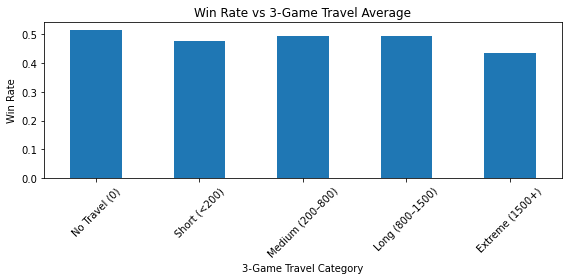

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = features.copy()

# Create travel categories using meaningful baseball thresholds
df["travel_3g_bucket"] = pd.cut(
    df["travel_3g_avg"],
    bins=[-0.1, 0.1, 200, 800, 1500, 10000],  # bins you can tune
    labels=["No Travel (0)", "Short (<200)", "Medium (200–800)", 
            "Long (800–1500)", "Extreme (1500+)"]
)

# Compute win rates per travel category
win_by_travel = df.groupby("travel_3g_bucket")["win_binary"].mean()

# Plot
win_by_travel.plot(kind="bar", figsize=(8,4))
plt.title("Win Rate vs 3-Game Travel Average")
plt.ylabel("Win Rate")
plt.xlabel("3-Game Travel Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
team_strength = df.groupby("team_code")["win_binary"].mean()
df["team_strength"] = df["team_code"].map(team_strength)
df["expected_win_prob"] = df["team_strength"]
df["performance_over_expected"] = df["win_binary"] - df["expected_win_prob"]



In [ ]:

df = features.copy()     # features = output of Step 9

# 1. Compute each team’s overall baseline win probability
team_strength = df.groupby("team_code")["win_binary"].mean()

# 2. Map the team-level strength back to each row
df["team_strength"] = df["team_code"].map(team_strength)

# 3. Expected win probability for each game
df["expected_win_prob"] = df["team_strength"]

# 4. Performance over expected = actual result minus expected result
df["performance_over_expected"] = df["win_binary"] - df["expected_win_prob"]

df[["team_code","game_date","win_binary","expected_win_prob","performance_over_expected"]].head()


,team_code,game_date,win_binary,expected_win_prob,performance_over_expected
0,BOS,2015-04-06,1,0.535278,0.464722
1,BOS,2015-04-08,0,0.535278,-0.535278
2,BOS,2015-04-09,1,0.535278,0.464722
3,BOS,2015-04-10,1,0.535278,0.464722
4,BOS,2015-04-11,1,0.535278,0.464722


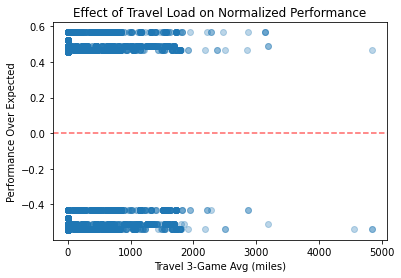

In [ ]:
plt.scatter(df["travel_3g_avg"], df["performance_over_expected"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--", alpha=0.6)
plt.xlabel("Travel 3-Game Avg (miles)")
plt.ylabel("Performance Over Expected")
plt.title("Effect of Travel Load on Normalized Performance")
plt.show()


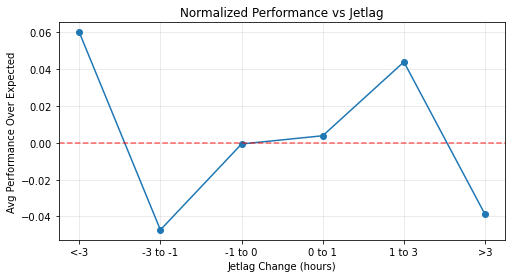

In [ ]:
df["jetlag_bucket"] = pd.cut(
    df["jetlag_change"],
    bins=[-10, -3, -1, 0, 1, 3, 10],
    labels=["<-3","-3 to -1","-1 to 0","0 to 1","1 to 3",">3"],
    include_lowest=True
)

poe_by_jetlag = df.groupby("jetlag_bucket")["performance_over_expected"].mean()

poe_by_jetlag.plot(marker="o", figsize=(8,4))
plt.axhline(0, color="red", linestyle="--", alpha=0.6)
plt.xlabel("Jetlag Change (hours)")
plt.ylabel("Avg Performance Over Expected")
plt.title("Normalized Performance vs Jetlag")
plt.grid(True, alpha=0.3)
plt.show()


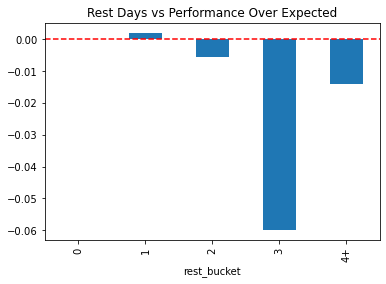

In [ ]:
df["rest_bucket"] = pd.cut(df["rest_days"], [-0.1,0,1,2,3,10], labels=["0","1","2","3","4+"])

df.groupby("rest_bucket")["performance_over_expected"].mean().plot(kind="bar")
plt.axhline(0, color="red", linestyle="--")
plt.title("Rest Days vs Performance Over Expected")
plt.show()
